In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.signal import find_peaks

np.random.seed(42)

### Variant Data

In [2]:
xl = pd.ExcelFile('data/gisaid_variants_statistics_2022_10_17_1253.xlsx')

first_flag = True
for sheet_name in xl.sheet_names[1:]:
    df = xl.parse(sheet_name)
    df_var = df[df.iloc[:, 0] == 'Canada']
    df_var = df_var.iloc[:, 2:].T
    df_var.rename(columns={df_var.columns[0]: sheet_name.replace('VOI', '').replace('VOC', '').strip()}, inplace=True)
    if first_flag:
        df_all = df_var.copy()
        first_flag = False
    else:
        df_all = df_all.join(df_var)
df_all.fillna(0, inplace=True)
df_all.index = pd.to_datetime(df_all.index)
df_all['total'] = df_all.sum(axis=1)
df_all.head()

,Omicron,Delta,Alpha,Beta,Gamma,Epsilon,Zeta,Eta,Theta,Iota,Kappa,Lambda,total
2019-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

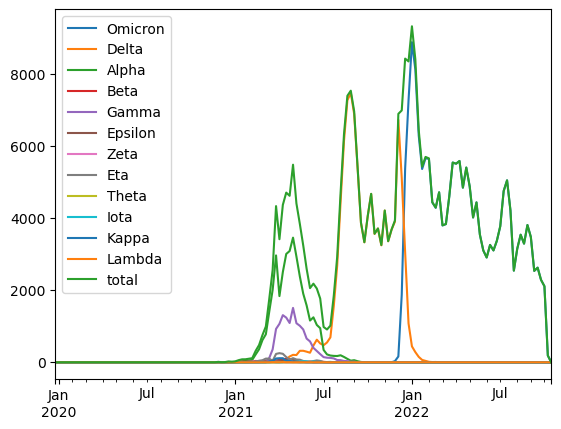

In [3]:
df_all.plot()

<AxesSubplot:>

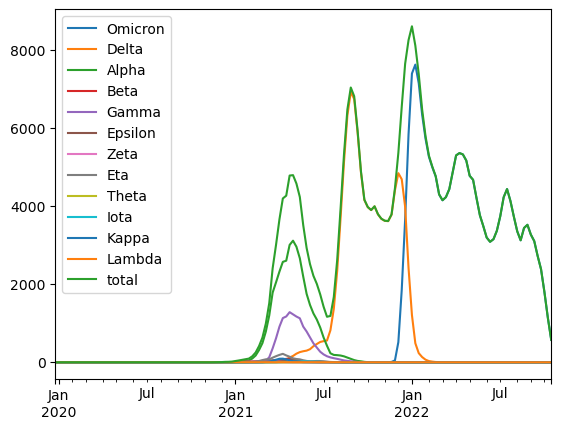

In [4]:
# 4 week moving avg
df_all_avg = df_all.copy()
for col in df_all_avg.columns:
    df_all_avg[col] = uniform_filter1d(df_all_avg[col], size=4).reshape(-1, 1)

df_all_avg.plot()

In [5]:
df_all_avg.to_csv('data/canada_variant_weekly_4w_avg.csv')

<AxesSubplot:>

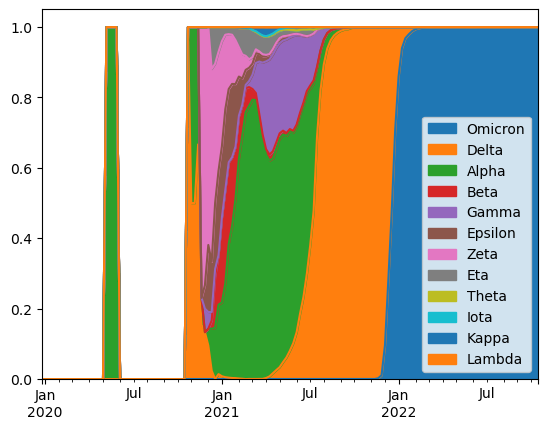

In [6]:
df_norm = df_all_avg.copy()
# # df_norm = df_norm / max(df_norm.sum(axis=1))
df_norm = df_norm.div(df_norm['total'], axis=0).copy()
df_norm.drop('total', axis=1, inplace=True)
df_norm.plot.area()

## Provincial Data

In [7]:
df = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
df_can = df[df['Country/Region'] == 'Canada']

# removing cruises
df_can = df_can[~df_can['Province/State'].isin(['Repatriated Travellers', 'Diamond Princess', 'Grand Princess'])]

df_can.drop(['Country/Region',  'Lat', 'Long'], axis=1, inplace=True)
df_can.rename({'Province/State': 'date'}, axis=1, inplace=True)
df_can = df_can.pivot_table(columns=['date'])
df_can.index = pd.to_datetime(df_can.index)
df_can.sort_index(inplace=True)
df_can['total'] = df_can.sum(axis=1)
df_can

date,Alberta,British Columbia,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon,total
2020-01-22,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,2,0,0,0,0,2
2020-01-24,0,0,0,0,0,0,0,0,3,0,0,0,0,3
2020-01-25,0,0,0,0,0,0,0,0,3,0,0,0,0,3
2020-01-26,0,0,0,0,0,0,0,0,3,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-03,607289,384900,149908,77460,51743,11511,125474,3531,1468342,51410,1202909,143747,4915,4283139
2022-10-04,607289,384900,149908,77460,51743,11511,125474,3531,1471071,52047,1203882,143747,4919,4287482
2022-10-05,607289,384900,149908,77460,51743,11511,125474,3531,1471071,52047,1204965,143747,4921,4288567
2022-10-06,607289,385599,150213,77460,51743,11511,125474,3531,1477588,52047,1206000,143747,4923,4297125


In [8]:
sum((df_can < 0).sum())

0

<AxesSubplot:>

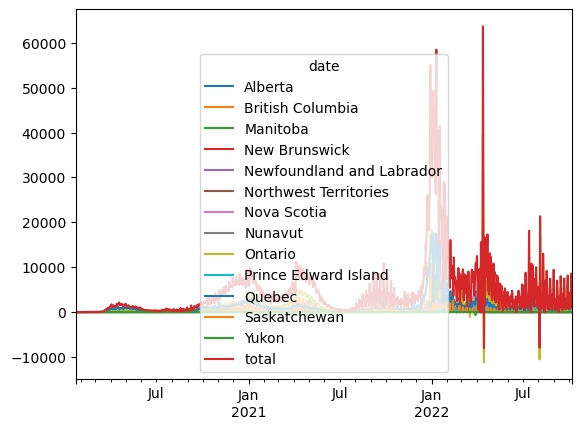

In [9]:
df_can2 = df_can - df_can.shift(1).fillna(0)
df_can2.plot()

<AxesSubplot:>

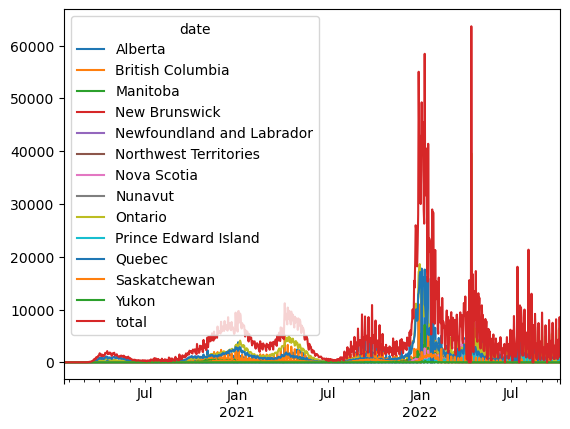

In [10]:
df_can2.drop('total', axis=1, inplace=True)
df_can2[df_can2 < 0] = 0
df_can2['total'] = df_can2.sum(axis=1)
df_can2.plot()

In [11]:
df_can2.to_csv('data/canada_regional.csv')

<AxesSubplot:>

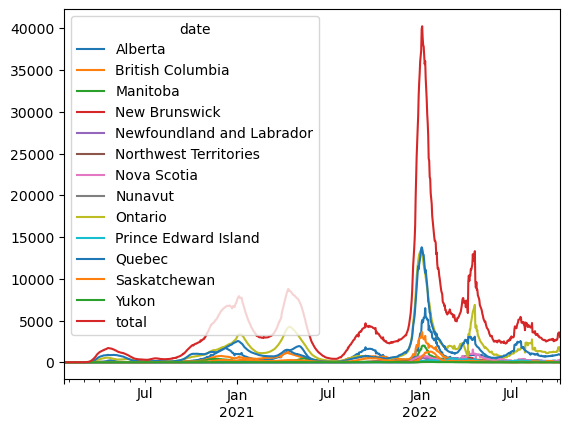

In [12]:
df_can_avg = df_can2.copy()
for col in df_can_avg.columns:
    df_can_avg[col] = uniform_filter1d(df_can_avg[col], size=14).reshape(-1, 1)

df_can_avg.plot()

In [13]:
df_can_avg.to_csv('data/canada_regional_14d_avg.csv')

### Lag btw cases, hospitals and deaths (OWID dataset)

In [14]:
df_owid = pd.read_csv('data/owid-covid-data.csv')
df_owid.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [15]:
df_owid[['continent', 'location', 'date', 'new_cases_smoothed']].groupby(['date', 'continent']).sum().pivot_table('new_cases_smoothed', ['date'], 'continent').reset_index()

continent,date,Africa,Asia,Europe,North America,Oceania,South America
0,2020-01-01,NaN,NaN,NaN,0.000,NaN,0.000
1,2020-01-02,NaN,NaN,NaN,0.000,NaN,0.000
2,2020-01-03,NaN,NaN,NaN,0.000,NaN,0.000
3,2020-01-04,NaN,0.000,NaN,0.000,NaN,0.000
4,2020-01-05,NaN,0.000,NaN,0.000,NaN,0.000
...,...,...,...,...,...,...,...
1018,2022-10-15,807.574,131884.713,254834.859,41807.287,6375.717,10045.286
1019,2022-10-16,758.716,128777.998,252821.287,41883.002,6786.003,10100.001
1020,2022-10-17,849.002,127732.857,258589.145,43765.859,4718.287,7734.430
1021,2022-10-18,605.430,132033.143,249615.287,38650.002,4692.287,6225.571


In [16]:
df_owid.groupby('continent').sum()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
continent,,,,,,,,,,,,,,,,,,,,,
Africa,5.941768e+09,12354914.0,1.234739e+07,1.374345e+08,256671.0,256300.047,6.295854e+08,1.911436e+06,1.903267e+06,8.238139e+06,...,936606.4,1055066.548,57187.620,3345714.92,28198.599,1.331675e+12,25847604.0,2708.41,4398.37,3.909424e+05
Asia,6.481326e+10,186514937.0,1.860630e+08,7.405197e+08,1481352.0,1478238.638,2.152937e+09,6.618401e+06,6.594670e+06,1.563654e+07,...,1465441.5,1773362.751,137276.920,3593648.70,33473.693,4.633845e+12,21740819.7,9193.42,15414.59,7.286552e+05
Europe,7.533644e+10,234022306.0,2.325641e+08,1.007640e+09,1954103.0,1948730.864,6.040057e+09,1.831631e+07,1.825591e+07,6.217000e+07,...,1380951.0,270826.473,215403.623,3713609.85,35905.221,8.002477e+11,119758818.5,33109.96,54243.35,6.502437e+06
North America,4.682948e+10,115078850.0,1.149391e+08,8.167690e+08,1515051.0,1512161.004,1.993684e+09,6.415433e+06,6.402929e+06,2.018992e+07,...,258315.5,966384.961,50931.220,2652979.83,16673.141,5.954116e+11,143312817.5,10360.80,15190.76,1.083506e+06
Oceania,2.372496e+09,12547376.0,1.246401e+07,4.521003e+06,20051.0,19926.440,6.228741e+08,3.342901e+06,3.327664e+06,2.593908e+06,...,250140.0,118281.793,19337.570,1153058.44,6555.279,4.303987e+10,-220161.4,-591.05,858.49,-4.353922e+04
South America,2.907538e+10,64067427.0,6.396223e+07,7.648593e+08,1307179.0,1306027.741,7.723870e+08,2.160952e+06,2.158573e+06,1.721462e+07,...,191030.4,378505.824,24087.980,943369.11,8823.460,4.205988e+11,57365023.1,21126.21,20879.04,1.586137e+06


<AxesSubplot:>

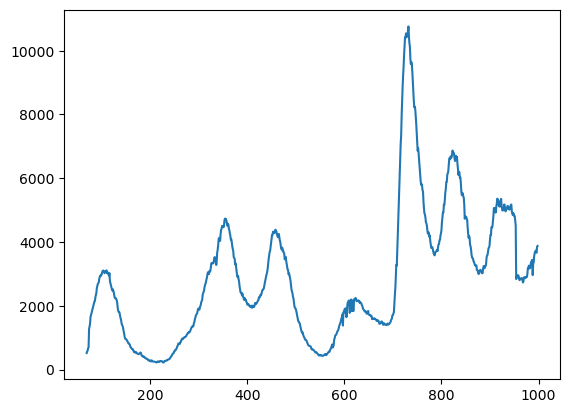

In [17]:
df_owid_can = df_owid[df_owid['location'] == 'Canada']
df_owid_can.reset_index(inplace=True)
df_owid_can['hosp_patients'].plot()

In [18]:
df_owid_can['date'] = pd.to_datetime(df_owid_can['date'])

C:\Users\wbhamed\AppData\Local\Temp\27\ipykernel_40900\3790322906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_owid_can['date'] = pd.to_datetime(df_owid_can['date'])


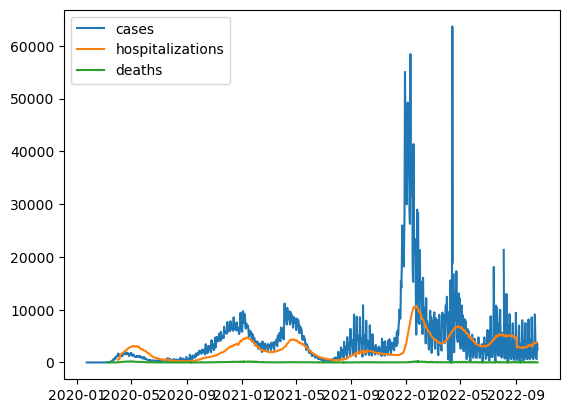

In [19]:
plt.plot(df_owid_can['date'], df_owid_can[['new_cases', 'hosp_patients', 'new_deaths']])
plt.legend(['cases', 'hospitalizations', 'deaths'])

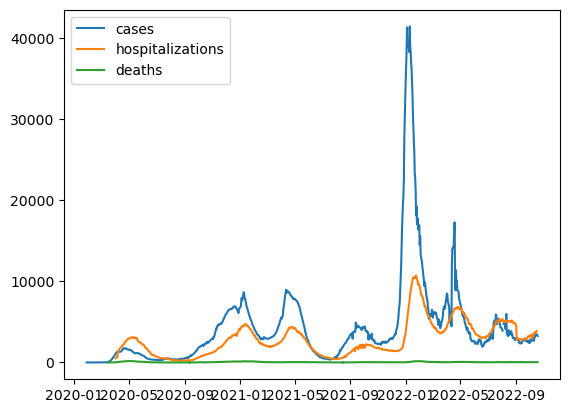

In [20]:
plt.plot(df_owid_can['date'], df_owid_can[['new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed']])
plt.legend(['cases', 'hospitalizations', 'deaths'])

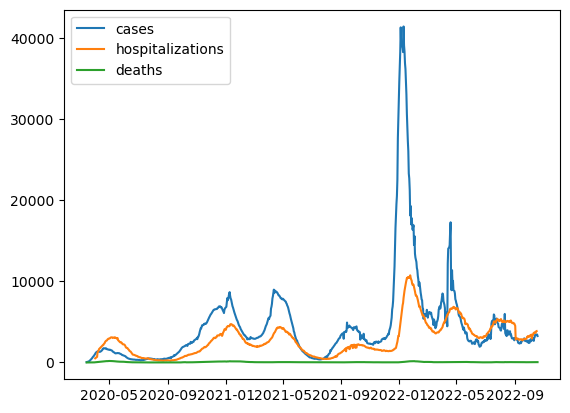

In [21]:
df_small = df_owid_can[['date', 'new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed']].copy()
df_small = df_small[~(df_small['new_cases_smoothed'].isna() | df_small['new_deaths_smoothed'].isna())]
df_small.reset_index(inplace=True)

plt.plot(df_small['date'], df_small[['new_cases_smoothed', 'hosp_patients', 'new_deaths_smoothed']])
plt.legend(['cases', 'hospitalizations', 'deaths'])

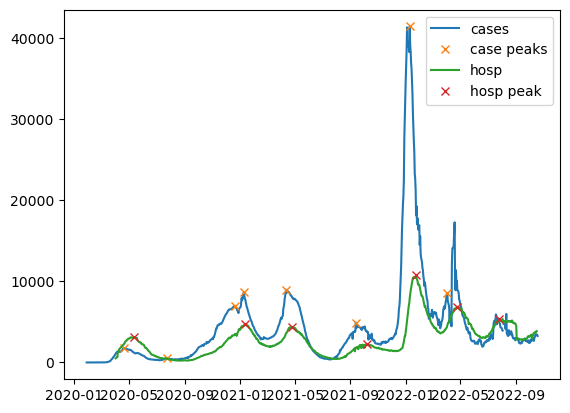

In [22]:
cases_peaks, _ = find_peaks(x=df_owid_can['new_cases_smoothed'], prominence=1, width=8)
plt.plot(df_owid_can['date'], df_owid_can['new_cases_smoothed'])
plt.plot(df_owid_can.loc[cases_peaks, 'date'], df_owid_can.loc[cases_peaks, 'new_cases_smoothed'], 'x')

hosp_peaks, _ = find_peaks(x=df_owid_can['hosp_patients'], prominence=1, width=8)
plt.plot(df_owid_can['date'], df_owid_can['hosp_patients'])
plt.plot(df_owid_can.loc[hosp_peaks, 'date'], df_owid_can.loc[hosp_peaks, 'hosp_patients'], 'x')
plt.legend(['cases', 'case peaks', 'hosp', 'hosp peak'])

In [23]:
total = 0
for x in hosp_peaks[:-1]:
    diffs = x - cases_peaks
    total += min(diffs[diffs > 2])
print('average lag (days):', total / (len(hosp_peaks)-1))

average lag (days): 19.833333333333332


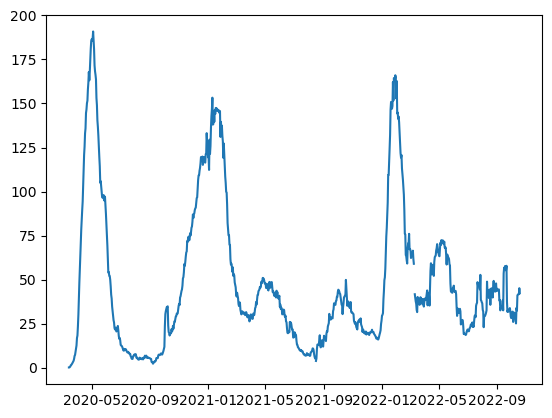

In [24]:
plt.plot(df_owid_can['date'], df_owid_can['new_deaths_smoothed'])